In [9]:
%matplotlib inline

import os

import torch
import yaml
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
from model import Fitted_DT
from utils.model import get_model, get_vocoder, get_param_num
from utils.tools import to_device_eval, to_device
from dataset import Dialogue_dataset_eval, Dialogue_dataset_neval
from scipy.io import wavfile
from utils.model import vocoder_infer

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mel(mel, title="Mel Spectrogram"):
    """
    Mel Spectrogram 시각화 함수.

    Args:
        mel (numpy.ndarray or torch.Tensor): Mel Spectrogram 데이터 (freq, time)
        title (str): 그래프 제목
    """
    if isinstance(mel, torch.Tensor):  # PyTorch 텐서일 경우 NumPy로 변환
        mel = mel.cpu().numpy()

    fig, ax = plt.subplots(figsize=(10, 4))  # 단일 그래프
    img = ax.imshow(mel, origin="lower", aspect="auto", cmap="viridis")
    ax.set_title(title, fontsize="medium")
    ax.set_xlabel("Time (frames)")
    ax.set_ylabel("Frequency (bins)")
    ax.tick_params(labelsize="small")
    
    # 컬러바 추가
    cbar = fig.colorbar(img, ax=ax, format="%+2.0f dB")
    cbar.set_label("Amplitude (dB)")

    plt.tight_layout()
    plt.show()

    return fig


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
restore_step =  100
model_name = "Fitted_v19_flowv2_Length_3"
preprocess_path = "./config/Fitted_DT/preprocess.yaml"
model_path = "./config/Fitted_DT/model.yaml"
train_path = "./config/Fitted_DT/train.yaml"
preprocess_config = yaml.load(open(preprocess_path, "r"), Loader=yaml.FullLoader)
model_config = yaml.load(open(model_path, "r"), Loader=yaml.FullLoader)
train_config = yaml.load(open(train_path, "r"), Loader=yaml.FullLoader)

In [5]:
print(model_config)

{'transformer': {'encoder_layer': 4, 'encoder_head': 2, 'encoder_hidden': 256, 'decoder_layer': 6, 'decoder_head': 2, 'decoder_hidden': 256, 'conv_filter_size': 1024, 'conv_kernel_size': [9, 1], 'encoder_dropout': 0.2, 'decoder_dropout': 0.2}, 'variance_predictor': {'filter_size': 256, 'kernel_size': 3, 'dropout': 0.5}, 'variance_embedding': {'pitch_quantization': 'linear', 'energy_quantization': 'linear', 'n_bins': 256}, 'dialogue_predictor': {'bert_in': 768, 'wav_in': 768, 'sbert_in': 512, 'n_mels': 80, 'history_length': 4, '2d_kernel': 3, '1d_kernel': 3, 'filter_channel': 256, 'melgru_layers': 3, 'n_heads': 2, 'dropout': 0.2}, 'flowdecoder': {'n_blocks': 6, 'n_sqz': 2, 'n_split': 4, 'dilation_rate': 1, 'kernel_size': 3, 'filter_channel': 192, 'n_layers': 6, 'dropout': 0.3}, 'multi_speaker': True, 'n_speaker': 2, 'max_seq_len': 10000, 'vocoder': {'model': 'HiFi-GAN', 'speaker': 'universal'}}


In [6]:
warmup = train_config["optimizer"]["warm_up_step"]
model = Fitted_DT(preprocess_config, model_config, warmup*2).to(device)
ckpt_path = os.path.join(
    train_config["path"]["ckpt_path"],
    "{}.pth.tar".format(restore_step),
)
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt["model"])
vocoder = get_vocoder(model_config, device)

/home/johnny9696/Desktop/Fitted_DT_Flow_condition/model/flowdecoder.py:54: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2416.)
  w_init = torch.qr(torch.FloatTensor(self.n_split, self.n_split).normal_())[0]
/home/johnny9696/anaconda3/envs/FS2/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Removing weight norm...


In [7]:
dataset = Dialogue_dataset_neval(
        "dialogue_val.txt", model_config, preprocess_config )
loader = DataLoader(
        dataset,
        batch_size=16,
        shuffle=False,
        collate_fn=dataset.collate_fn,
    )

21


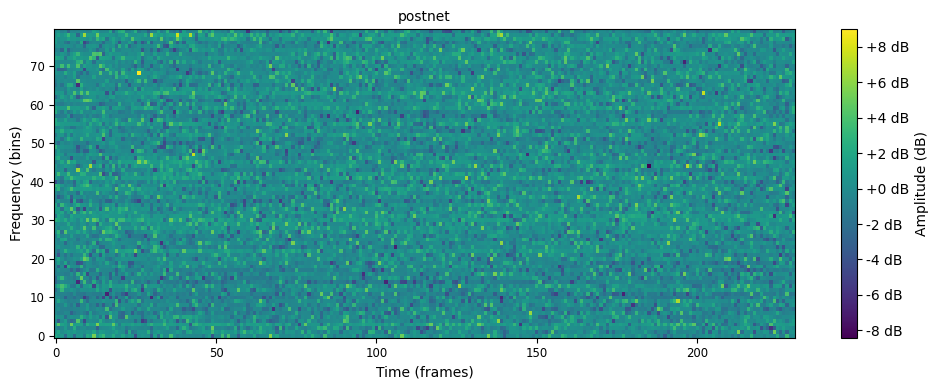

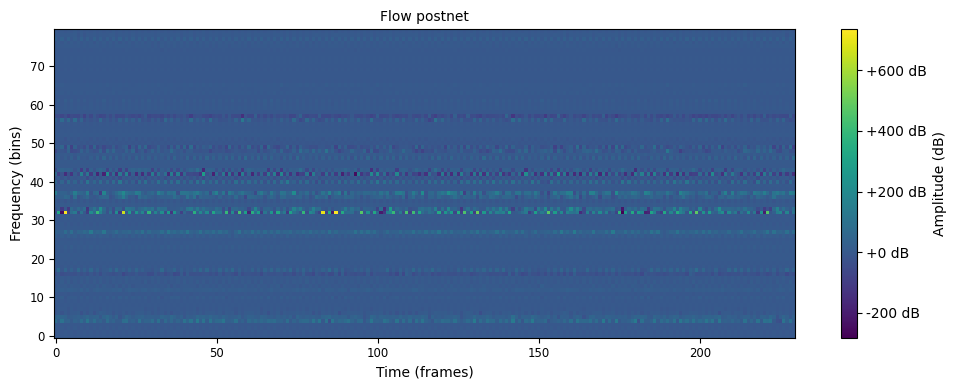

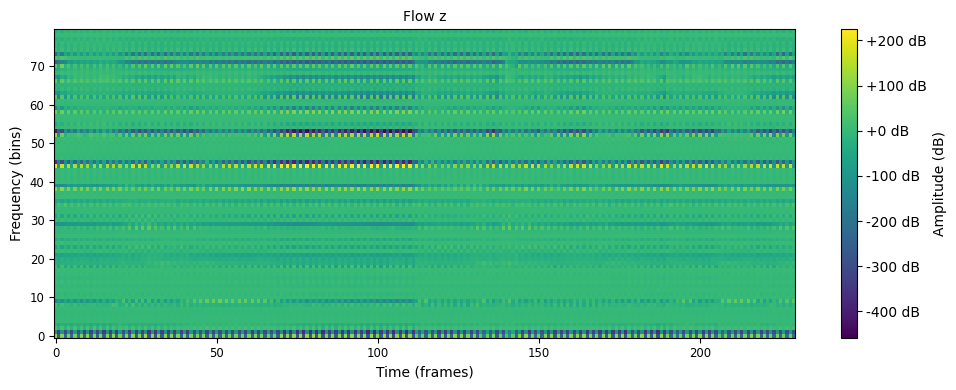

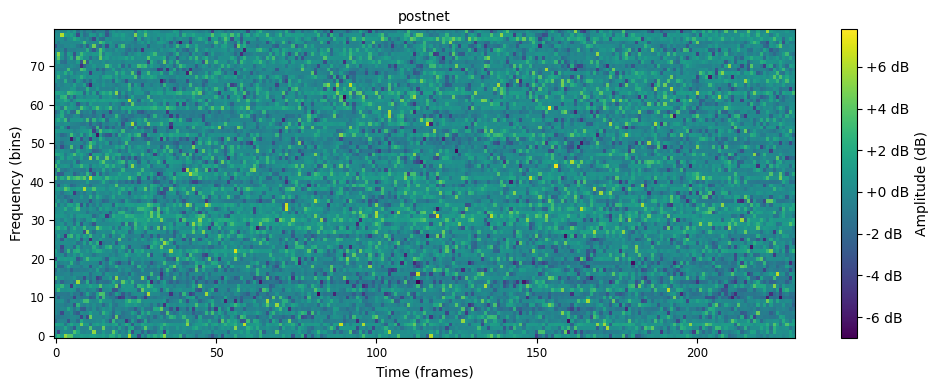

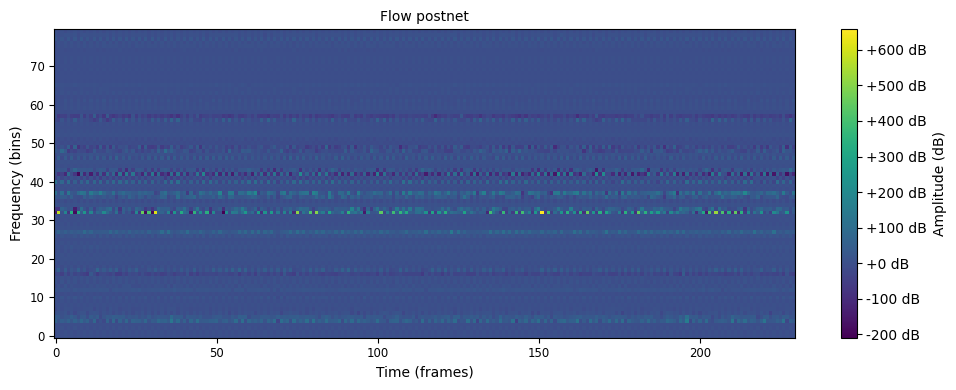

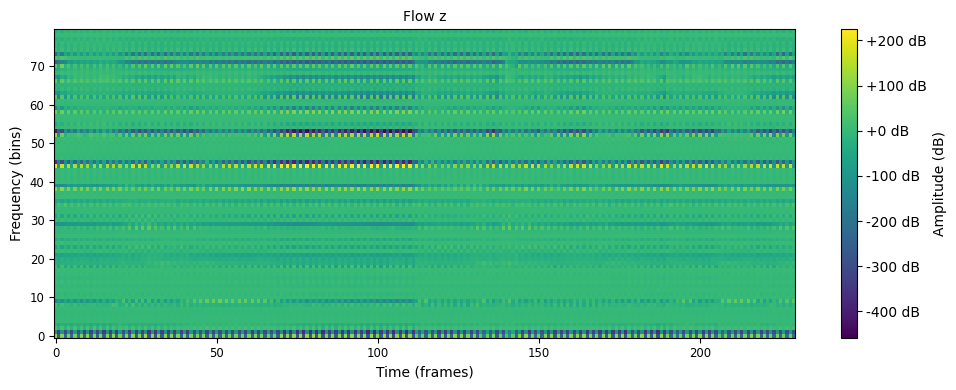

[22994 21987 23015 ... -2447 -2878 -2678]
[  -863 -12908  -9365 ...  14287  14019  21140]
1


In [10]:
step = 0
for batchs, basename_list in loader:
    for indx, batch in enumerate(batchs):
        print(len(batch))
        batch = to_device(batch, device)
        with torch.no_grad():
            output = model(*(batch), gen = True, steps = 10000)
            output1 = model(*(batch), gen = False, steps = 10000)
            plot_mel(output[-1].transpose(-1,-2).squeeze(0), title = "postnet")
            plot_mel(output[1].squeeze(0), title = "Flow postnet")
            plot_mel(output1[0][0].squeeze(0), title = "Flow z")
            mel_spec = output[1]

        if vocoder is not None:
            wav_prediction = vocoder_infer(
                mel_spec,
                vocoder,
                model_config,
                preprocess_config,
            )[0]
            wav_prediction_1 = vocoder_infer(
                output[-1].transpose(-1,-2),
                vocoder,
                model_config,
                preprocess_config,
            )[0]
            print(wav_prediction)
            print(wav_prediction_1)
        basename = basename_list[indx]
        data_path = basename.split("_")
        os.makedirs(os.path.join(train_config["path"]["result_path"], data_path[-1]), exist_ok=True)
        wav_path = os.path.join(train_config["path"]["result_path"], data_path[-1], basename+".wav")
        wavfile.write(wav_path, 22050, wav_prediction)
    step = step + 1
    print(step)
    break


In [ ]:
dataset = Dialogue_dataset_eval(
        "train.txt", model_config, preprocess_config )
loader = DataLoader(
        dataset,
        batch_size=16,
        shuffle=False,
        collate_fn=dataset.collate_fn,
    )

In [ ]:
step = 0
for batchs, basename_list in loader:
    for indx, batch in enumerate(batchs):
        batch = to_device_eval(batch, device)
        with torch.no_grad():
            output = model(*(batch), gen = True, steps = 0)
            mel_spec = output[-1].transpose(-1,-2)
        if vocoder is not None:
            wav_prediction = vocoder_infer(
                mel_spec,
                vocoder,
                model_config,
                preprocess_config,
            )[0]
        basename = basename_list[indx]
        data_path = basename.split("_")
        os.makedirs(os.path.join(train_config["path"]["result_path"], data_path[-1]), exist_ok=True)
        wav_path = os.path.join(train_config["path"]["result_path"], data_path[-1], basename+".wav")
        wavfile.write(wav_path, 22050, wav_prediction)
    step = step + 1
    print(step)


In [95]:
import math
def MLELoss_det(z, logdet = None, x_mask = None):
    z_logs = torch.zeros_like(z*x_mask)
    print(z_logs)
    l = torch.sum(z_logs) + 0.5 * torch.sum(z**2 * torch.exp(-2 * z_logs))
    print(l)
    if logdet is not None:
        l = l - torch.sum(logdet)
    print(l)
    if x_mask == None:
        l = l / torch.sum(torch.ones_like(z))
    else:
        l = l / torch.sum(torch.ones_like(z).masked_fill(x_mask, 0))
        print(torch.sum(torch.ones_like(z).masked_fill(x_mask, 0)))
    l = l + 0.5 * math.log(2 * math.pi)
    print(l)
    return l

MLELoss_det(output1[0][0], output1[0][1], output1[9])

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0')
tensor(1.3469e+14, device='cuda:0')
tensor(1.3469e+14, device='cuda:0')
tensor(18400., device='cuda:0')
tensor(7.3201e+09, device='cuda:0')


tensor(7.3201e+09, device='cuda:0')